In [1]:
# General
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random

# #import sklearn
# import sklearn
# from sklearn import *

# %matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# import graphviz
# import xgboost

# # For imbalanced learning
# import imblearn

import warnings
warnings.filterwarnings('ignore')

In [2]:
# # Initialization: Load shared functions and simulated data 

# # Load shared functions
# !curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
# %run shared_functions.py

# # Get simulated data from Github repository
# if not os.path.exists("simulated-data-raw"):
#     !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-raw
        

In [3]:
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [4]:
DIR_INPUT='../data/raw/simulated-data-raw/' 

BEGIN_DATE = "2023-01-01"
END_DATE = "2023-12-31"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: total: 1min 8s
Wall time: 1min 23s
35373001 transactions loaded, containing 48593 fraudulent transactions


In [5]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2023-01-01 00:00:02,48113,62780,108.66,2,0,0,0
1,1,2023-01-01 00:00:07,46622,95086,33.89,7,0,0,0
2,2,2023-01-01 00:00:11,19752,73646,41.55,11,0,0,0
3,3,2023-01-01 00:00:17,6160,24605,31.83,17,0,0,0
4,4,2023-01-01 00:00:21,32593,29798,24.86,21,0,0,0


[Text(0.5, 0, 'Time (days)'), Text(0, 0.5, 'Number of transactions')]

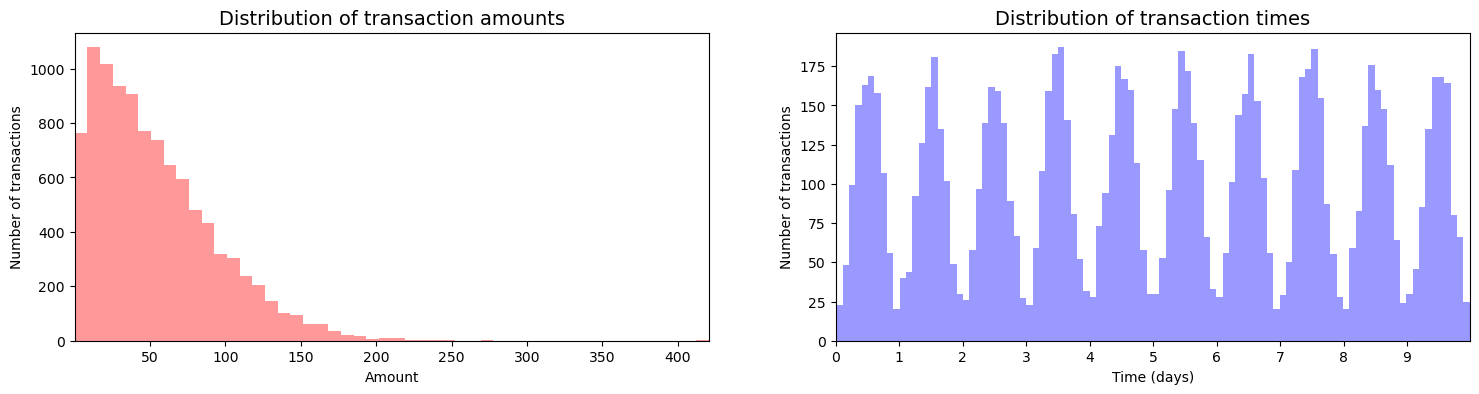

In [6]:
distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")


In [7]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [8]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

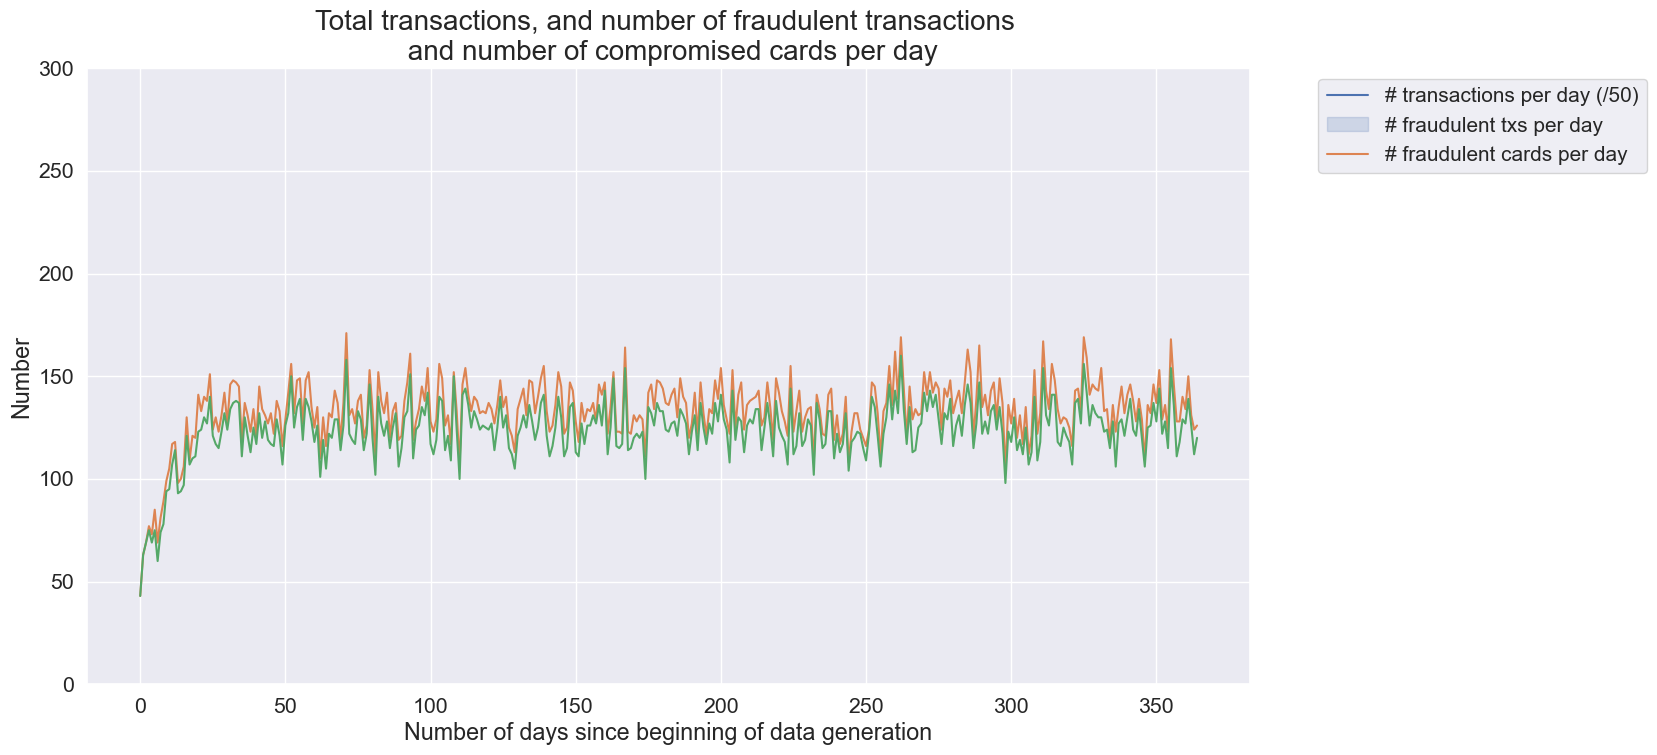

In [9]:
fraud_and_transactions_stats_fig

In [10]:
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6

    return int(is_night)

def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions


In [11]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

CPU times: total: 43 s
Wall time: 45.9 s


In [12]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

CPU times: total: 37.1 s
Wall time: 40.1 s


In [13]:
%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: total: 5min 15s
Wall time: 6min 47s


In [14]:
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: total: 10min 52s
Wall time: 13min 57s


In [15]:
%time transactions_df

CPU times: total: 0 ns
Wall time: 998 µs


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2023-01-01 00:00:02,48113,62780,108.66,2,0,0,0,1,...,1.0,108.660000,1.0,108.660000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2023-01-01 00:00:07,46622,95086,33.89,7,0,0,0,1,...,1.0,33.890000,1.0,33.890000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2023-01-01 00:00:11,19752,73646,41.55,11,0,0,0,1,...,1.0,41.550000,1.0,41.550000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2023-01-01 00:00:17,6160,24605,31.83,17,0,0,0,1,...,1.0,31.830000,1.0,31.830000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2023-01-01 00:00:21,32593,29798,24.86,21,0,0,0,1,...,1.0,24.860000,1.0,24.860000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35372996,35372996,2023-12-31 23:59:25,46694,92673,85.46,31535965,364,0,0,1,...,28.0,87.984286,108.0,94.564074,1.0,0.0,7.0,0.0,34.0,0.0
35372997,35372997,2023-12-31 23:59:25,28283,4163,24.14,31535965,364,0,0,1,...,16.0,59.291875,88.0,63.245568,0.0,0.0,5.0,0.0,25.0,0.0
35372998,35372998,2023-12-31 23:59:32,21609,73195,75.64,31535972,364,0,0,1,...,12.0,117.068333,51.0,90.880784,1.0,0.0,4.0,0.0,24.0,0.0
35372999,35372999,2023-12-31 23:59:39,37255,26537,11.63,31535979,364,0,0,1,...,9.0,54.756667,35.0,56.886286,3.0,0.0,13.0,0.0,33.0,0.0


In [16]:
# transactions_df[transactions_df.TX_FRAUD==1]